Course_items = ['平时成绩', '实验成绩', '期末成绩']  / ['平时成绩',  '期末成绩'] / ['期末成绩', ]    
计算任意课程目标 1,2,3...X

版本修改记录
1. V X10-6 修改numpy库升级产生的不兼容问题  np.nan ==> np.array(' ') ==> Score_Average_str = np.r_[ np.array(' '), np.array('平均分'), Score_Average ] 

常见报错
1. AxisError: axis 1 is out of bounds for array of dimension 1  ## 原因：excel表格 课程目标编号缺失，比如没有3，只有1和2；但是你的课程目标选择了3个


In [22]:
import os
import xlwings
import numpy as np
import pandas as pd 

In [23]:
Course_target_numlist=[1,2,3,4,5]     # 任意设置课程目标   1,2,3,4...,X      
Course_items_type = 1         # 课程项目类型 1 ， 2,  3 
                              # Course_items_type =3 暂时有问题 
if Course_items_type == 1: 
    Course_items = ['平时成绩', '实验成绩', '期末成绩']  
elif Course_items_type == 2: 
    Course_items = ['平时成绩',  '期末成绩']      # 注意修改excel 各项比例和为1
elif Course_items_type == 3:
    Course_items = ['期末成绩', ]

In [24]:

# 获得表格分数数据
def Get_Score_Table_info(Score_Table_Class):
      # 分数表格-类别 
    # print(Score_Table_Class)  

    Course_target_class = np.array(Score_Table_Class.iloc[5,4:-1])  # 课程目标类别
    print(Course_target_class) 
    Student_score = np.array(Score_Table_Class.iloc[8:,4:-1]) # 学生分数（各题）
    # Student_score[:,0]
    Student_info = np.array(Score_Table_Class.iloc[8:,2:4])       # 学生信息 

    Score_Table_Head = Score_Table_Class.iloc[:8,:] # 表头数据

    # 课程目标 类别 
    loc_target_Numall=[]
    for i_num in Course_target_numlist:
        # print(i_num)
        res = np.argwhere(Course_target_class==i_num).reshape((-1)) # 满足条件的索引值 Course_target_class==1/2/3/.../X
        # print(res)
        loc_target_Numall.append(res)
        
    # loc_target_one = np.argwhere(Course_target_class==1).reshape((-1)) # 满足条件的索引值 
    # loc_target_two = np.argwhere(Course_target_class==2).reshape((-1)) # 满足条件的索引值 
    # loc_target_three = np.argwhere(Course_target_class==3).reshape((-1)) # 满足条件的索引值 
    # # print(loc_target_one,loc_target_two,loc_target_three)
    # loc_target_Numall=[loc_target_one, loc_target_two, loc_target_three] 

    print('loc_target_Numall',loc_target_Numall)
    # print('loc_target_Numall', loc_target_Numall) 

    # 每题满分 
    Fullscore_each_examination_question = np.array((Score_Table_Class.iloc[6,4:-1])).reshape((-1)) 
    # print(Fullscore_each_examination_question)
    return Student_score, Fullscore_each_examination_question, loc_target_Numall, Student_info, Course_target_class, Score_Table_Head


In [25]:
# 达成度目标=NUM 计算
### 数据索引
# 学生分数
def Achievement_Degree_Calcultion_function(Student_score, Fullscore_each_examination_question, 
                                           loc_target_Num, RATIO_SCORE_CLASS):  
    scorelist_student_target_Num=[] 

    for i in range(len(loc_target_Num)): 
        scorelist_student_target_Num.append( Student_score[:,loc_target_Num[i]] ) 
    scorearr_target_Num = np.array(scorelist_student_target_Num).T 
    # print('学生分数', scorearr_target_Num) 

    # 每题题目分数 
    FullscoreEEQ_list_target_Num=[] 
    for i in range(len(loc_target_Num)):   
        FullscoreEEQ_list_target_Num.append(Fullscore_each_examination_question[loc_target_Num[i]] )  

    # print('每题题目分数', FullscoreEEQ_list_target_Num)

    ### 数据计算
    # 实际满分(百分制) - 比例满分 - 学生得分 - 得分比例 - 目标1得分
    RealFullscore_target_Num_Total = sum(FullscoreEEQ_list_target_Num) / np.sum(Fullscore_each_examination_question)  *100  # 实际满分(百分制)
    # print('实际满分(百分制)', RealFullscore_target_Num_Total)
    # 比例满分 (乘以比例后的分数) 
    RatioFullscore_target_Num = RealFullscore_target_Num_Total * RATIO_SCORE_CLASS 
    # 学生得分(百分制)
    Score_student_target_Num_Total = np.sum(scorearr_target_Num, axis=1) / np.sum(Fullscore_each_examination_question) *100 # 实际得分(百分制)
    
    # 得分比例
    if RealFullscore_target_Num_Total == 0:
        Ratio_score_target_Num = np.around((Score_student_target_Num_Total/(RealFullscore_target_Num_Total+1e-10)).astype(float) ,decimals=4)
    else:
        Ratio_score_target_Num = np.around((Score_student_target_Num_Total/RealFullscore_target_Num_Total).astype(float) ,decimals=4)
    # print( Ratio_score_target_Num ) 
    # 目标1得分 = 比例满分 * 得分比例 
    Score_target_Num =np.around( ( RatioFullscore_target_Num * Ratio_score_target_Num).astype(float) ,decimals=4)
    # print(Score_target_Num)
    

    return np.c_[Score_student_target_Num_Total, Ratio_score_target_Num, Score_target_Num], RealFullscore_target_Num_Total, RatioFullscore_target_Num 
    

In [26]:
# 获得新的表头
def Score_Table_Head_Deal(Score_Table_Head):
    w_table = Score_Table_Head.shape[1]
    Table_Head = Score_Table_Head
    print('w_table', w_table)
    new_col = Table_Head.columns.to_list() + list(range(w_table, w_table + 3*len(Course_target_numlist)+2))
    # print('Table_Head.columns.to_list()', Table_Head.columns.to_list())
    Table_Head = Table_Head.reindex(columns=new_col)
    print('new_col',new_col)
    
    namestr_list=[]
    for i_num in Course_target_numlist:
        namestr_list.append(['{}'.format(i_num),'{}°'.format(i_num), '{}得分'.format(i_num) ])
    namestr_list.append(['计算成绩', '实际成绩'])
    namestr_list = [i for item in namestr_list for i in item]
    namecol_add = namestr_list 
    print('namecol_add',namecol_add)   
    # namecol_add = ['1', '1°','1得分','2', '2°','2得分','3', '3°','3得分', '计算成绩', '实际成绩']

    Table_Head.iloc[1,w_table:] = namecol_add
    Table_Head.drop(columns=[0,1],axis=1,inplace=True)
    Table_Head.columns = list(range(0,Table_Head.shape[1]))
    return Table_Head

In [27]:
# 整体平均分 + 各项学生得分占比
def AverageScore_ScoreRatio(DataScore_Cal_CourseClass_Num, Fullscore_each_examination_question):
    print('DataScore_Cal_CourseClass_Num', DataScore_Cal_CourseClass_Num)
    Score_Average =  np.around(np.mean(DataScore_Cal_CourseClass_Num[:,2:],axis = 0).astype(float),decimals=2) 
    print('Score_Average',Score_Average) 
    FS_EEQ_T = np.r_[Fullscore_each_examination_question, np.sum(Fullscore_each_examination_question)]
    print('FS_EEQ_T.shape',FS_EEQ_T) 
   
    W_scoreratio = np.around( (Score_Average[:-(3*len(Course_target_numlist)+2)]/(FS_EEQ_T + 1e-10)).astype(float) , decimals=2 )

    # print(W_scoreratio) 
    Score_Average_str = np.r_[np.array(' '), np.array('平均分'), Score_Average ]  # 修改 np.nan ==》 np.array(' ') 2023.11.29
    W_scoreratio_str  = np.r_[np.array(' '), np.array('得分率'), W_scoreratio,  np.full((3*len(Course_target_numlist)+2), np.nan) ] # 修改 np.nan ==》 np.array(' ') 2023.11.29
    Score_Average_str = Score_Average_str.reshape(-1, len(Score_Average_str))
    W_scoreratio_str  = W_scoreratio_str.reshape(-1, len(W_scoreratio_str))
    return Score_Average_str, W_scoreratio_str

In [28]:
# 获得EXCEL==含指定字符
def get_excel_file(specified_character ='成绩表模板'): 
    excel_name =''
    for i in (os.listdir()):
        if i.split('.')[-1] == 'xlsx' or i.split('.')[-1] == 'xls':
            if specified_character in i.split('.')[0]:
                excel_name = i
    if excel_name=='':        
        print('当前文件夹下, 无excel文件') 
        print('or 无指定字符(%s)的.xlsx或xls文件'%specified_character)
    else:
        return excel_name

In [29]:

# 主函数 - 课程类别（期末成绩-实验成绩-实验成绩）
def main_Achievement_Degree_Calcultion_CourseClassNum(Score_table, RATIO_SCORE_CLASS): 
    # 获得表格分数数据 
    Student_score, Fullscore_each_examination_question, loc_target_Numall, Student_info, Course_target_class, Score_Table_Head \
            = Get_Score_Table_info(Score_Table_Class = Score_table) 

    # 计算达成度数据
    for TargetNum in Course_target_numlist: 
        res_ADC, RealFullscore, RatioFullscore = Achievement_Degree_Calcultion_function(Student_score, Fullscore_each_examination_question, 
                                                loc_target_Numall[TargetNum-1], RATIO_SCORE_CLASS) 

        if TargetNum==1:
            Calresult_target_Numall = np.c_[res_ADC]
            RealFullscore_target_all  = np.c_[RealFullscore]
            RatioFullscore_target_all = np.c_[RatioFullscore]
        elif TargetNum>1:
            Calresult_target_Numall = np.c_[Calresult_target_Numall, res_ADC]                                        
            RealFullscore_target_all  = np.c_[RealFullscore_target_all, RealFullscore]
            RatioFullscore_target_all = np.c_[RatioFullscore_target_all, RatioFullscore]

    RealFullscore_target_all,RatioFullscore_target_all = RealFullscore_target_all[0], RatioFullscore_target_all[0] 

    # 计算总分 + 实际总分 
    ScoreTotal_Cal_CourseClass_Num = np.around( np.sum(Calresult_target_Numall[:,2::3] , axis=1).astype(float), decimals=2) 
    # print(ScoreTotal_Cal_CourseClass_Num )   
     
    Student_score_percentage = np.sum(Student_score, axis=1) / np.sum(Fullscore_each_examination_question) *100  # 百分制
    ScoreTotal_Real_CourseClass_Num = np.around( ( Student_score_percentage * RATIO_SCORE_CLASS).astype(float), decimals=2) 
    # print(ScoreTotal_Real_CourseClass_Num)  

    # 拼接所有数据-1
    DataScore_Cal_CourseClass_Num = np.c_[Student_info, Student_score, Student_score_percentage ,np.around(Calresult_target_Numall.astype(float), decimals=2), \
                                    ScoreTotal_Cal_CourseClass_Num, ScoreTotal_Real_CourseClass_Num]

    Score_Average_str, W_scoreratio_str = AverageScore_ScoreRatio(DataScore_Cal_CourseClass_Num, Fullscore_each_examination_question)

    # 拼接所有数据-2
    DataScore_Cal_all_CourseClass_Num = np.r_[DataScore_Cal_CourseClass_Num, Score_Average_str, W_scoreratio_str]
    # print(DataScore_Cal_all_CourseClass_Num)

    # 最终结果表格写入excel
    # 数据表头 
    Final_Table_Head = Score_Table_Head_Deal(Score_Table_Head=Score_Table_Head)
    Final_Table_Head.iloc[6,-3*len(Course_target_numlist)-2:-2:3] = RealFullscore_target_all
    Final_Table_Head.iloc[7,-3*len(Course_target_numlist)-2:-2:3] = RatioFullscore_target_all
    # 拼接表头与数据
    DataScore_Cal_df=pd.DataFrame(DataScore_Cal_all_CourseClass_Num)
    Result_table_Final = pd.concat([Final_Table_Head,DataScore_Cal_df]) 
    return Result_table_Final


In [30]:

# 自动载入  '成绩表模板' 
ExcelName = get_excel_file(specified_character ='成绩表模板') 
ExcelName_path = os.path.join(os.getcwd(), ExcelName)  # 打开的excel必须关闭，否则没有权限 Permission denied 

for sheetname in Course_items: 
    Score_table = pd.read_excel(ExcelName_path, index_col=None, header=None, sheet_name=sheetname) 

    if sheetname == '平时成绩':
        RATIO_pingshi_score = Score_table.iloc[1,4] # 平时成绩比例
        ADC_ScoreClass_pingshi = main_Achievement_Degree_Calcultion_CourseClassNum(Score_table, RATIO_SCORE_CLASS = RATIO_pingshi_score)   
    elif sheetname == '实验成绩':
        RATIO_shiyan_score =  Score_table.iloc[1,4] # 实验成绩比例
        ADC_ScoreClass_shiyan = main_Achievement_Degree_Calcultion_CourseClassNum(Score_table, RATIO_SCORE_CLASS = RATIO_shiyan_score)
    elif sheetname == '期末成绩':
        RATIO_qimo_score = Score_table.iloc[1,4] # 期末成绩比例
        ADC_ScoreClass_qimo = main_Achievement_Degree_Calcultion_CourseClassNum(Score_table, RATIO_SCORE_CLASS = RATIO_qimo_score)
        # 课程目标对应的题号
        Questionnum_to_Targetnum_qimo = np.array(Score_table.loc[[3,5]])

with pd.ExcelWriter('课程达成度评价结果.xlsx', mode='w') as writer: 
    for sheetname in Course_items:
        if sheetname == '平时成绩':
            ADC_ScoreClass_pingshi.to_excel(writer, sheet_name='平时成绩',header=False,index=False,startrow=0, startcol=0)
        elif sheetname == '实验成绩':
            ADC_ScoreClass_shiyan.to_excel(writer, sheet_name='实验成绩',header=False,index=False,startrow=0, startcol=0)
        elif sheetname == '期末成绩':
            ADC_ScoreClass_qimo.to_excel(writer, sheet_name='期末成绩',header=False,index=False,startrow=0, startcol=0)

[1 2 3 5 4]
loc_target_Numall [array([0], dtype=int64), array([1], dtype=int64), array([2], dtype=int64), array([4], dtype=int64), array([3], dtype=int64)]
DataScore_Cal_CourseClass_Num [['180101081102' '吴晓伟' 54 ... 4.5 18.0 18.0]
 ['200101011001' '田佳林' 57 ... 4.75 19.0 19.0]
 ['200101011002' '刘凤翔' 51 ... 4.25 17.0 17.0]
 ...
 ['200101011126' '王小江' 51 ... 4.75 17.5 17.5]
 ['200101011135' '邱利民' 57 ... 4.75 19.0 19.0]
 ['200101011139' '冉维天' 51 ... 4.25 17.0 17.0]]
Score_Average [53.96 53.74 27.15 45.48  0.   90.16 26.98  0.9   5.4  26.87  0.9   5.37
 13.58  0.91  2.72  0.    0.    0.   22.74  0.91  4.55 18.03 18.03]
FS_EEQ_T.shape [60 60 30 50 0 200]
w_table 10
new_col [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
namecol_add ['1', '1°', '1得分', '2', '2°', '2得分', '3', '3°', '3得分', '4', '4°', '4得分', '5', '5°', '5得分', '计算成绩', '实际成绩']
[4 4 4 4 1.0 2.0 3.0 5.0]
loc_target_Numall [array([4], dtype=int64), array([5], dtype=int64), array([6], 

In [31]:
# 课程目标对应的题号
def Get_Questionnum_to_courseTargetnum(Questionnum_to_Targetnum_qimo): 
    res_Questionnum_dict = {}
    for val in Course_target_numlist: 
        # print('Questionnum_to_Targetnum', Questionnum_to_Targetnum_qimo) 
        index_coursetarget = np.where(Questionnum_to_Targetnum_qimo[1,:]==val) 
        res = Questionnum_to_Targetnum_qimo[0, [index_coursetarget]] # np 列表索引
        res = res.flatten() # 压缩
        res_i = np.insert(res, np.arange(1,len(res)),', ') # 间隔插入逗号
        print(res_i)
        res_Questionnum_dict['课程目标'+str(val)]=''.join(res_i) #串接字符串
    print(res_Questionnum_dict) 

    head_row_pd=pd.DataFrame(np.array([['课程目标对应的考试题号',''],['课程目标编号', '试卷题号']]))
    res_Questionnum_dict_pd_value = pd.DataFrame(list(res_Questionnum_dict.items()))
    res_Questionnum_dict_pd = pd.concat([head_row_pd , res_Questionnum_dict_pd_value],axis =0 ,ignore_index=True).reset_index (drop=True)
    return res_Questionnum_dict_pd 

res_Questionnum_dict_pd = Get_Questionnum_to_courseTargetnum(Questionnum_to_Targetnum_qimo)    
with pd.ExcelWriter('课程达成度评价结果.xlsx', mode='a',if_sheet_exists ='replace') as writer: 
    res_Questionnum_dict_pd.to_excel(writer, sheet_name='课程目标对应的考试题号',header=False,index=False,startrow=0, startcol=0)

['T1' ', ' 'T2' ', ' 'T4' ', ' 'T5' ', ' 'T6' ', ' 'T7' ', ' 'T9' ', '
 'X1' ', ' 'X2' ', ' 'X3' ', ' 'X4' ', ' 'X5' ', ' 'X6' ', ' 'X9' ', '
 'X10' ', ' 'P1' ', ' 'P2' ', ' 'P3' ', ' 'F3' ', ' 'F4' ', ' 'J1']
['T10' ', ' 'F2' ', ' 'J2']
['T3' ', ' 'T8' ', ' 'X7' ', ' 'X8' ', ' 'P4' ', ' 'P5' ', ' 'F1']
['K0']
['J3']
{'课程目标1': 'T1, T2, T4, T5, T6, T7, T9, X1, X2, X3, X4, X5, X6, X9, X10, P1, P2, P3, F3, F4, J1', '课程目标2': 'T10, F2, J2', '课程目标3': 'T3, T8, X7, X8, P4, P5, F1', '课程目标4': 'K0', '课程目标5': 'J3'}


In [32]:
### 达成度分析表 函数库开始 
# 达成度分析表1 = 平时-实验-期末 psq
def Data_Summary_ADC_Target_num_psq(targetnum,  #
                ADCData_pingshi_arr, # 平时作业  ADC计算结果 
                ADCData_shiyan_arr,  # 实验      ADC计算结果 
                ADCData_qimo_arr,    # 期末      ADC计算结果     
                ADC_RatioFullScore_pingshi_arr,  # 课程目标比例满分-平时
                ADC_RatioFullScore_shiyan_arr,   # 课程目标比例满分-实验
                ADC_RatioFullScore_qimo_arr      # 课程目标比例满分-期末
    ):
    ### 数据表
    #数据抽取 - ADC-Targetnum-res 
    Target_num_ADC_Scoreclassall = np.c_[ ADCData_pingshi_arr[:,targetnum-1], ADCData_shiyan_arr[:,targetnum-1],  
                                                                            ADCData_qimo_arr[:,targetnum-1]  ] 
    # 求和  
    Target_num_ADC_Scoreclassall_sum = np.sum(Target_num_ADC_Scoreclassall, axis = 1)  
    print('Target_num_ADC_Scoreclassall_sum', Target_num_ADC_Scoreclassall_sum)
    # 达成度比例
    Target_num_ADC_RatioFullScore_Scoreclassall = np.c_[ADC_RatioFullScore_pingshi_arr[targetnum-1],   
                                                        ADC_RatioFullScore_shiyan_arr[targetnum-1],    
                                                        ADC_RatioFullScore_qimo_arr[targetnum-1]       ]     
    Target_num_ADC_RatioFullScore_Scoreclassall_sum = np.around( (np.sum(Target_num_ADC_RatioFullScore_Scoreclassall, axis = 1)).astype(float), decimals=2)  # 目标1    
     
    Target_num_ADC_ratio_W  = np.around((Target_num_ADC_Scoreclassall_sum / (Target_num_ADC_RatioFullScore_Scoreclassall_sum + 1e-10) ).astype(float), decimals=2)    
    print('Target_num_ADC_ratio_W', Target_num_ADC_ratio_W)    

    # 达成度汇总
    Target_num_ADC_data_x = np.c_[ Target_num_ADC_Scoreclassall, Target_num_ADC_Scoreclassall_sum, Target_num_ADC_ratio_W]      
    Target_num_ADC_data_x_mean = np.expand_dims( np.around( np.mean(Target_num_ADC_data_x, axis=0).astype(float),  decimals=2)  , axis=0 )   # 一维转置 == 拓展0维即可   
    Ratiovalue_ADC = np.expand_dims( np.array([Target_num_ADC_data_x_mean[0,-1], np.nan, np.nan, np.nan, np.nan]), axis=0 )     
    Target_num_ADC_data_all_df = pd.DataFrame( np.r_[Target_num_ADC_data_x, Target_num_ADC_data_x_mean, Ratiovalue_ADC] )       

    ### 表头
 
    Head_str_row0 = [ '课程目标{}(满分{}分)'.format(targetnum, Target_num_ADC_RatioFullScore_Scoreclassall_sum[0]), '', '', '','']   

    Head_str_row1 = [ '平时得分', '实验得分', '期末得分', '小计', '课程目标达成情况']   

    Head_str_row2 = ['满分{}分'.format(ADC_RatioFullScore_pingshi_arr[targetnum-1]), '满分{}分'.format(ADC_RatioFullScore_shiyan_arr[targetnum-1]) ,   
                    '满分{}分'.format(ADC_RatioFullScore_qimo_arr[targetnum-1]),   '', '']   


    Head_str_row3 =['S{}({})'.format(targetnum,'平时'), 'S{}({})'.format(targetnum,'实验'), 'S{}({})'.format(targetnum,'期末'),   
                    '∑S{}(各考核环节)'.format(targetnum), 'W{}'.format(targetnum)]    


    Head_table_Target_num= pd.DataFrame( np.c_[Head_str_row0,Head_str_row1,Head_str_row2,Head_str_row3].T )  

    # Target_num 拼接表  
    Res_Target_num_df = pd.concat([Head_table_Target_num, Target_num_ADC_data_all_df])  
    return Res_Target_num_df

# 达成度分析表2 = 平时-期末 pq
def Data_Summary_ADC_Target_num_pq(targetnum,  #
                ADCData_pingshi_arr, # 平时作业  ADC计算结果                 
                ADCData_qimo_arr,    # 期末      ADC计算结果     
                ADC_RatioFullScore_pingshi_arr,  # 课程目标比例满分-平时                
                ADC_RatioFullScore_qimo_arr      # 课程目标比例满分-期末
    ):
    ### 数据表
    #数据抽取 - ADC-Targetnum-res 
    Target_num_ADC_Scoreclassall = np.c_[ ADCData_pingshi_arr[:,targetnum-1], ADCData_qimo_arr[:,targetnum-1]  ] 
    # 求和  
    Target_num_ADC_Scoreclassall_sum = np.sum(Target_num_ADC_Scoreclassall, axis = 1)  
    print('Target_num_ADC_Scoreclassall_sum', Target_num_ADC_Scoreclassall_sum)
    # 达成度比例
    Target_num_ADC_RatioFullScore_Scoreclassall = np.c_[ADC_RatioFullScore_pingshi_arr[targetnum-1],                                                           
                                                        ADC_RatioFullScore_qimo_arr[targetnum-1]       ]     
    Target_num_ADC_RatioFullScore_Scoreclassall_sum = np.around( (np.sum(Target_num_ADC_RatioFullScore_Scoreclassall, axis = 1)).astype(float), decimals=2)  # 目标1    
     
    Target_num_ADC_ratio_W  = np.around((Target_num_ADC_Scoreclassall_sum / Target_num_ADC_RatioFullScore_Scoreclassall_sum).astype(float), decimals=2)    
    print('Target_num_ADC_ratio_W', Target_num_ADC_ratio_W)    

    # 达成度汇总
    Target_num_ADC_data_x = np.c_[ Target_num_ADC_Scoreclassall, Target_num_ADC_Scoreclassall_sum, Target_num_ADC_ratio_W]      
    Target_num_ADC_data_x_mean = np.expand_dims( np.around( np.mean(Target_num_ADC_data_x, axis=0).astype(float),  decimals=2)  , axis=0 )   # 一维转置 == 拓展0维即可   
    Ratiovalue_ADC = np.expand_dims( np.array([Target_num_ADC_data_x_mean[0,-1], np.nan, np.nan, np.nan, ]), axis=0 )     # T2 
    print('shape', Target_num_ADC_data_x.shape, Target_num_ADC_data_x_mean.shape, Ratiovalue_ADC.shape)
    Target_num_ADC_data_all_df = pd.DataFrame( np.r_[Target_num_ADC_data_x, Target_num_ADC_data_x_mean, Ratiovalue_ADC] )       

    ### 表头
 
    Head_str_row0 = [ '课程目标{}(满分{}分)'.format(targetnum, Target_num_ADC_RatioFullScore_Scoreclassall_sum[0]), '', '', '']   

    Head_str_row1 = [ '平时得分', '期末得分', '小计', '课程目标达成情况']   

    Head_str_row2 = ['满分{}分'.format(ADC_RatioFullScore_pingshi_arr[targetnum-1]),   
                    '满分{}分'.format(ADC_RatioFullScore_qimo_arr[targetnum-1]),   '', '']   


    Head_str_row3 =['S{}({})'.format(targetnum,'平时'), 'S{}({})'.format(targetnum,'期末'),   
                    '∑S{}(各考核环节)'.format(targetnum), 'W{}'.format(targetnum)]    


    Head_table_Target_num= pd.DataFrame( np.c_[Head_str_row0,Head_str_row1,Head_str_row2,Head_str_row3].T )  

    # Target_num 拼接表  
    Res_Target_num_df = pd.concat([Head_table_Target_num, Target_num_ADC_data_all_df])  
    return Res_Target_num_df 

# 达成度分析表3 = 期末 q
def Data_Summary_ADC_Target_num_q(targetnum,  #                
                ADCData_qimo_arr,    # 期末      ADC计算结果                     
                ADC_RatioFullScore_qimo_arr      # 课程目标比例满分-期末
    ):
    ### 数据表
    #数据抽取 - ADC-Targetnum-res 
    Target_num_ADC_Scoreclassall = [ ADCData_qimo_arr[:,targetnum-1]  ] 
    print('Target_num_ADC_Scoreclassall', Target_num_ADC_Scoreclassall)
    # 求和  
    Target_num_ADC_Scoreclassall_sum = Target_num_ADC_Scoreclassall 
    print('Target_num_ADC_Scoreclassall_sum', Target_num_ADC_Scoreclassall_sum)
    # 达成度比例
    Target_num_ADC_RatioFullScore_Scoreclassall = [ ADC_RatioFullScore_qimo_arr[targetnum-1] ]    
    print('Target_num_ADC_RatioFullScore_Scoreclassall', Target_num_ADC_RatioFullScore_Scoreclassall)    
    
    Target_num_ADC_RatioFullScore_Scoreclassall_sum = np.around( np.array(Target_num_ADC_RatioFullScore_Scoreclassall).astype(float), decimals=2)  # 目标1    
     
    Target_num_ADC_ratio_W  = np.around((Target_num_ADC_Scoreclassall_sum / (Target_num_ADC_RatioFullScore_Scoreclassall_sum+1e-10)).astype(float), decimals=2)    
    print('Target_num_ADC_ratio_W', Target_num_ADC_ratio_W)    

    # 达成度汇总
    Target_num_ADC_data_x = np.r_[ Target_num_ADC_Scoreclassall, Target_num_ADC_Scoreclassall_sum, Target_num_ADC_ratio_W].T      
    Target_num_ADC_data_x_mean = np.expand_dims( np.around( np.mean(Target_num_ADC_data_x, axis=0).astype(float),  decimals=2)  , axis=0 )   # 一维转置 == 拓展0维即可   
    Ratiovalue_ADC = np.expand_dims( np.array([Target_num_ADC_data_x_mean[0,-1], np.nan, np.nan,  ]), axis=0 )     # T1 
    print('shape', Target_num_ADC_data_x.shape, Target_num_ADC_data_x_mean.shape, Ratiovalue_ADC.shape)
    
    Target_num_ADC_data_all_df = pd.DataFrame( np.r_[Target_num_ADC_data_x, Target_num_ADC_data_x_mean, Ratiovalue_ADC] )       

    ### 表头
 
    Head_str_row0 = [ '课程目标{}(满分{}分)'.format(targetnum, Target_num_ADC_RatioFullScore_Scoreclassall_sum[0]), '', '']   

    Head_str_row1 = [  '期末得分', '小计', '课程目标达成情况']   

    Head_str_row2 = ['满分{}分'.format( ADC_RatioFullScore_qimo_arr[targetnum-1]),   '', '']   


    Head_str_row3 =['S{}({})'.format(targetnum,'期末'),   
                    '∑S{}(各考核环节)'.format(targetnum), 'W{}'.format(targetnum)]    


    Head_table_Target_num= pd.DataFrame( np.c_[Head_str_row0,Head_str_row1,Head_str_row2,Head_str_row3].T )  

    # Target_num 拼接表  
    Res_Target_num_df = pd.concat([Head_table_Target_num, Target_num_ADC_data_all_df])  
    return Res_Target_num_df 

In [33]:
### 学生信息-表 
def Get_Res_Snum_Student(ADC_ScoreClass_qimo):
    Head_table_Snum_Student = pd.DataFrame(np.empty((4,2), dtype=str))       
    Head_table_Snum_Student.iloc[:]=np.nan         
    Head_table_Snum_Student.iloc[0,0:2] = ['学号', '姓名']              
    
    Info_Snum_Student_df = ADC_ScoreClass_qimo.iloc[8:-2,:2] 
    Tail_table_Snum_Student = pd.DataFrame([[np.nan, '平均值'], [np.nan, '课程目标达成情况']], index=np.arange(Info_Snum_Student_df.shape[0],Info_Snum_Student_df.shape[0]+2,1))
            
    Res_Snum_Student_df = pd.concat([Head_table_Snum_Student, Info_Snum_Student_df, Tail_table_Snum_Student ], axis= 0 )

    return Res_Snum_Student_df

In [34]:
### 计算ADC总成绩-表 
def Cal_ADC_Totalscore_table(Res_Target_numAll_df): 
    if len(Course_items)==3:
        ind_space = 5
    elif len(Course_items)==2:
        ind_space = 4
    elif len(Course_items)==1:
        ind_space = 3

    # ADC 总成绩
    Res_Target_eachscoreTotal_arr = Res_Target_numAll_df.iloc[4:-2 ,3:-1:ind_space].values
    Res_Target_totalscore = np.around( np.sum(Res_Target_eachscoreTotal_arr,axis=1).astype(float), decimals=2 )
    
    # ADC 平均
    Avg_Res_Target_totalscore = np.around( np.mean(Res_Target_totalscore, axis=0).astype(float), decimals=2 ) 
    # ADC 比例分值平均
    Avg_Res_Ratiovalue_ADC  = np.around( np.mean( Res_Target_numAll_df.iloc[-1 ,0:-1:ind_space].values, axis=0).astype(float), decimals=2 )
    # 拼接值 【总成绩 + 平均 + 比例分值平均】
    Res_ADC_Calscore  = np.r_[Res_Target_totalscore, Avg_Res_Target_totalscore, Avg_Res_Ratiovalue_ADC ] 
    Res_ADC_Realscore = Res_ADC_Calscore
    Res_ADC_Cal_Realscore_df = pd.DataFrame( np.c_[Res_ADC_Calscore, Res_ADC_Realscore] ) 

    # ADC总成绩表头
    Head_table_totalscore = pd.DataFrame(np.empty((4,2), dtype=str))       
    Head_table_totalscore.iloc[:]=np.nan         
    Head_table_totalscore.iloc[0,0:2] = ['计算成绩', '实际成绩'] 

    # ADC_总成绩拼接
    Res_totalscore_df = pd.concat([Head_table_totalscore,Res_ADC_Cal_Realscore_df], axis=0)
    # Res_totalscore_df.drop(labels= [1], axis=1, inplace=True) # 删除不需要最后一列
    Res_totalscore_df=Res_totalscore_df.iloc[:, :-1]  # 删除不需要最后一列

    return Res_totalscore_df

In [35]:
# 计算达成度目标 不合格的比例与数量 + 索引ADC均值
def Cal_ADC_failed_num_ratio( namestr_ADCtargetnum ,res_targetnum_df ):
    # print('res_targetnum_df = ' , res_targetnum_df.iloc[4:-2,4] ) # 
    if len(Course_items)==3:
        ind_pos = 4
    elif len(Course_items)==2:
        ind_pos = 3
    elif len(Course_items)==1:
        ind_pos = 2

    res_ADC_targetnum = np.array(res_targetnum_df.iloc[4:-2, ind_pos])
    # print('res_ADC_targetnum_1 ',np.sum(res_ADC_targetnum_1 < 0.68))
    num_ADC_failed = np.sum(res_ADC_targetnum < 0.68) # ADC 不达标的数量
    r_ADC_failed = np.around( ( np.sum(res_ADC_targetnum < 0.68)/np.size(res_ADC_targetnum)).astype(float), decimals=2)  # ADC 不达标的比例
    print(namestr_ADCtargetnum , 'ADC 不达标的比例 = ',num_ADC_failed, '\n', 'ADC 不达标的数量 =', r_ADC_failed) 
    res_ADC_targetnum_mean = res_targetnum_df.iloc[-1,0]  
    return [namestr_ADCtargetnum, num_ADC_failed, r_ADC_failed, res_ADC_targetnum_mean]

In [36]:
### 达成度分析表 [索引问题]  

# 数据抽取 - ADC-res - 
for sheetname in Course_items: 
    if sheetname == '平时成绩':
        ADCData_pingshi_arr  = ADC_ScoreClass_pingshi.iloc[8:-2,-3*len(Course_target_numlist):-2:3].values # 平时作业  ADC计算结果
        ADC_RatioFullScore_pingshi_arr = np.around( (ADC_ScoreClass_pingshi.iloc[7,-3*len(Course_target_numlist)-2:-2:3].values).astype(float), decimals=2)   # 课程目标比例满分-平时
    elif sheetname == '实验成绩':
        ADCData_shiyan_arr   = ADC_ScoreClass_shiyan.iloc[8:-2,-3*len(Course_target_numlist):-2:3].values  # 实验      ADC计算结果 
        ADC_RatioFullScore_shiyan_arr  = np.around( (ADC_ScoreClass_shiyan.iloc[7,-3*len(Course_target_numlist)-2:-2:3].values).astype(float), decimals=2 )   # 课程目标比例满分-实验
    elif sheetname == '期末成绩':
        ADCData_qimo_arr     = ADC_ScoreClass_qimo.iloc[8:-2,-3*len(Course_target_numlist):-2:3].values    # 期末      ADC计算结果
        ADC_RatioFullScore_qimo_arr    = np.around( (ADC_ScoreClass_qimo.iloc[7,-3*len(Course_target_numlist)-2:-2:3].values).astype(float), decimals=2   )   # 课程目标比例满分-期末

# 课程目标各项比例分 == 期末对应的目标1-2-3比例满分 - 
if  ('平时成绩' in Course_items) and  ('实验成绩' in Course_items) and ('期末成绩' in Course_items) :
    R_courseTarget_to_totalscore = np.c_[ADC_RatioFullScore_pingshi_arr, ADC_RatioFullScore_shiyan_arr, ADC_RatioFullScore_qimo_arr] / 100   # 课程目标各项比例分 == 平时、实验、期末对应的目标1-2-3比例满分
elif  ('平时成绩' in Course_items) and  ('期末成绩' in Course_items) :
    R_courseTarget_to_totalscore = np.c_[ADC_RatioFullScore_pingshi_arr, ADC_RatioFullScore_qimo_arr] / 100   # 课程目标各项比例分 == 平时、期末对应的目标1-2-3比例满分
elif  '期末成绩' in Course_items:
    R_courseTarget_to_totalscore = np.c_[ADC_RatioFullScore_qimo_arr] / 100    # 课程目标各项比例分 == 期末对应的目标1-2-3比例满分 
   

## 汇总课程目标1-2-3 达成度
Res_Target_numAll_df = pd.DataFrame() 
res_numall_ADC_Fnr = []  # 课程目标完成情况 - 结果   
for targetnum in Course_target_numlist: # [1,2,3]   
    if  ('平时成绩' in Course_items) and  ('实验成绩' in Course_items) and ('期末成绩' in Course_items) :
        res_df = Data_Summary_ADC_Target_num_psq(targetnum,   
                        ADCData_pingshi_arr,
                        ADCData_shiyan_arr,
                        ADCData_qimo_arr,        
                        ADC_RatioFullScore_pingshi_arr, 
                        ADC_RatioFullScore_shiyan_arr, 
                        ADC_RatioFullScore_qimo_arr ) 
    elif  ('平时成绩' in Course_items) and  ('期末成绩' in Course_items) :
        res_df = Data_Summary_ADC_Target_num_pq(targetnum,   
                        ADCData_pingshi_arr,
                        ADCData_qimo_arr,        
                        ADC_RatioFullScore_pingshi_arr, 
                        ADC_RatioFullScore_qimo_arr ) 
    elif  '期末成绩' in Course_items:
        res_df = Data_Summary_ADC_Target_num_q(targetnum,   
                        ADCData_qimo_arr,        
                        ADC_RatioFullScore_qimo_arr ) 
    print(res_df) 
    Res_Target_numAll_df = pd.concat([Res_Target_numAll_df, res_df], axis = 1)    
    res1_ADC_Fnr = Cal_ADC_failed_num_ratio('ADC达成度目标{}'.format(targetnum), res_df)  # 课程目标完成情况 - 结果    
    res_numall_ADC_Fnr.append(res1_ADC_Fnr)    

print('res_numall_ADC_Fnr', res_numall_ADC_Fnr)   
    
Res_Snum_Student_df = Get_Res_Snum_Student(ADC_ScoreClass_qimo)     # 学生信息   
Res_totalscore_df = Cal_ADC_Totalscore_table(Res_Target_numAll_df)  # ADC计算总分   
Res_Table_ADC_DataAll_df = pd.concat([Res_Snum_Student_df, Res_Target_numAll_df, Res_totalscore_df],axis = 1)   # 达成度计算总表    
Res_Table_ADC_DataAll_df # ADC 达成度计算总表

#写入表格
with pd.ExcelWriter('课程达成度评价结果.xlsx', mode='a',if_sheet_exists ='replace') as writer: 
    Res_Table_ADC_DataAll_df.to_excel(writer, sheet_name='课程目标达成度分析',header=False,index=False,startrow=0, startcol=0)



Target_num_ADC_Scoreclassall_sum [16.4 19.7 20.6 18.1 19.9 22.7 24.7 21.7 20.7 23.9 21.4 25.9 25.1 26.7
 28.4 25.2 24.1 22.1 24.6 23.4 22.2 22.2 29.2 25.2 27.9 23.7 22.2 20.9
 21.6 22.4 23.4 21.1 26.1 22.4 21.4 20.4 21.9 22.6 22.9 21.6 21.6 24.6
 20.4 20.9 21.2 25.6 24.9 21.9 21.9 19.9 22.7 23.1 27.4 26.2 26.9 23.1
 26.9 21.7 18.1 26.1 24.4 22.9 27.2 24.2 22.6 18.6 23.2 23.6]
Target_num_ADC_ratio_W [0.48 0.58 0.61 0.53 0.59 0.67 0.73 0.64 0.61 0.7  0.63 0.76 0.74 0.79
 0.84 0.74 0.71 0.65 0.72 0.69 0.65 0.65 0.86 0.74 0.82 0.7  0.65 0.61
 0.64 0.66 0.69 0.62 0.77 0.66 0.63 0.6  0.64 0.66 0.67 0.64 0.64 0.72
 0.6  0.61 0.62 0.75 0.73 0.64 0.64 0.59 0.67 0.68 0.81 0.77 0.79 0.68
 0.79 0.64 0.53 0.77 0.72 0.67 0.8  0.71 0.66 0.55 0.68 0.69]
                 0       1        2           3         4
0   课程目标1(满分34.0分)                                       
1             平时得分    实验得分     期末得分          小计  课程目标达成情况
2           满分6.0分  满分0.0分  满分28.0分                      
3           S1(平时)  

In [37]:
# 课程目标完成情况与均值
str_row =[['统计', '达成度低于0.68的学生数量', '达成度低于0.68的学生比例', '达程度平均值' ],] 
ADC_Fnrm_pd = pd.DataFrame(  np.r_[str_row, res_numall_ADC_Fnr]  ) 
# 写入excel
with pd.ExcelWriter('课程达成度评价结果.xlsx', mode='a',if_sheet_exists ='replace') as writer: 
    ADC_Fnrm_pd.to_excel(writer, sheet_name='课程目标完成情况与均值',header=False,index=False,startrow=0, startcol=0) 


In [38]:
# 考核环节与课程目标体系的关联关系 = 表 

def Cal_R_courseTarget_to_totalscore(R_courseTarget_to_totalscore ): 
    # print('转置 = 行=平时=实验=期末', ) 
    R_courseTarget_to_totalscore_T  = R_courseTarget_to_totalscore.T*100 # 课程目标各项比例分 == 平时、实验、期末对应的目标1-2-3比例满分
    R_courseTarget_rowsum_pingshi_shiyan_qimo = np.sum(R_courseTarget_to_totalscore_T,axis=1)           #平时、实验、期末比例满分和
    print('列求和', R_courseTarget_rowsum_pingshi_shiyan_qimo )
    R_courseTarget_colsum_pingshi_shiyan_qimo = np.sum(R_courseTarget_to_totalscore_T,axis=0)           #目标1-2-3比例满分和
    print('行求和', R_courseTarget_colsum_pingshi_shiyan_qimo )

    ### 表头 
    R1 = np.around( (R_courseTarget_to_totalscore_T).astype(float), decimals=3) 
    R1_rowt = np.around( R_courseTarget_rowsum_pingshi_shiyan_qimo.astype(float), decimals=3) 
    R1_colt = np.around( R_courseTarget_colsum_pingshi_shiyan_qimo.astype(float), decimals=3) 


    Head_str_row0 = ['课程目标及观测点',]
    Head_str_row1 = [ '考核方式', ]


    for i_num in Course_target_numlist:
        Head_str_row0.append('课程目标{}'.format(i_num))
        Head_str_row1.append('观测点{}'.format(i_num))
        
    Head_str_row0.append('合计')
    Head_str_row1.append('')
    print(Head_str_row0)
    print(Head_str_row1)

    
    Head_str_row_item = []
    Head_str_row2 =[]
    for i_item,j_c in zip(Course_items,range(len(Course_items))):
        Head_str_row2.append( '{}Ti（{}）'.format(i_item, i_item[:2]) )
        for i_num, i_t in zip(Course_target_numlist, range(len(Course_target_numlist))):   
            Head_str_row2.append('T{}（{}）={}'.format(i_num, i_item[:2] ,R1[j_c][i_t]),) 
        Head_str_row2.append('T（{}）={}'.format(i_item[:2], R1_rowt[j_c])) 
        Head_str_row_item.append(Head_str_row2)
        Head_str_row2 = []
    Head_str_row2 
    print(Head_str_row_item)


    Head_str_row3 = ['总计（分）Ti', ]
    for i_num, i_t in zip(Course_target_numlist, range(len(Course_target_numlist)) ):    
            Head_str_row3.append('T{}={}'.format(i_num , R1_colt[i_t]) ) 
    Head_str_row3.append('T={}'.format(100))  # 提示警告
    print(Head_str_row3)

    Head_str_all = Head_str_row_item
    Head_str_all.insert(0,Head_str_row0)
    Head_str_all.insert(1,Head_str_row1)
    Head_str_all.append(Head_str_row3)
    Table_course_examine= pd.DataFrame(Head_str_all) 

    # #  简单程序如下：
    # i, j=0, 0

    # Head_str_row0 = [ '课程目标及观测点', '课程目标1', '课程目标2', '课程目标3',  '合计']

    # Head_str_row1 = [ '考核方式','观测点X', '观测点X' , '观测点X', ''] 

    # Head_str_row2 = ['平时成绩Ti（平时）', 'T1（平时）={}'.format(R1[i][j]), 'T2（平时）={}'.format(R1[i][j+1]), 'T3（平时）={}'.format(R1[i][j+2]), 'T（平时）={}'.format(R1_rowt[i])]
    # Head_str_row3 = ['实验成绩Ti（实验）', 'T1（实验）={}'.format(R1[i+1][j]), 'T2（实验）={}'.format(R1[i+1][j+1]), 'T3（实验）={}'.format(R1[i+1][j+2]), 'T（实验）={}'.format(R1_rowt[i+1])]
    # Head_str_row4 = ['期末成绩Ti（期末）', 'T1（期末）={}'.format(R1[i+2][j]), 'T2（期末）={}'.format(R1[i+2][j+1]), 'T3（期末）={}'.format(R1[i+2][j+2]), 'T（期末）={}'.format(R1_rowt[i+2])]
    # Head_str_row5 = ['总计（分）Ti', 'T1={}'.format(R1_colt[i]), 'T2={}'.format(R1_colt[i+1]), 'T3={}'.format(R1_colt[i+2]), 'T={}'.format(100)] 
    print(Table_course_examine)  

    # 写入excel
    with pd.ExcelWriter('课程达成度评价结果.xlsx', mode='a',if_sheet_exists ='replace') as writer: 
        Table_course_examine.to_excel(writer, sheet_name='考核环节与课程目标体系的关联关系',header=False,index=False,startrow=0, startcol=0)

Cal_R_courseTarget_to_totalscore( R_courseTarget_to_totalscore ) 

列求和 [20. 30. 50.]
行求和 [34.  14.5 11.5 30.  10. ]
['课程目标及观测点', '课程目标1', '课程目标2', '课程目标3', '课程目标4', '课程目标5', '合计']
['考核方式', '观测点1', '观测点2', '观测点3', '观测点4', '观测点5', '']
[['平时成绩Ti（平时）', 'T1（平时）=6.0', 'T2（平时）=6.0', 'T3（平时）=3.0', 'T4（平时）=0.0', 'T5（平时）=5.0', 'T（平时）=20.0'], ['实验成绩Ti（实验）', 'T1（实验）=0.0', 'T2（实验）=0.0', 'T3（实验）=0.0', 'T4（实验）=30.0', 'T5（实验）=0.0', 'T（实验）=30.0'], ['期末成绩Ti（期末）', 'T1（期末）=28.0', 'T2（期末）=8.5', 'T3（期末）=8.5', 'T4（期末）=0.0', 'T5（期末）=5.0', 'T（期末）=50.0']]
['总计（分）Ti', 'T1=34.0', 'T2=14.5', 'T3=11.5', 'T4=30.0', 'T5=10.0', 'T=100']
            0            1           2           3            4           5  \
0    课程目标及观测点        课程目标1       课程目标2       课程目标3        课程目标4       课程目标5   
1        考核方式         观测点1        观测点2        观测点3         观测点4        观测点5   
2  平时成绩Ti（平时）   T1（平时）=6.0  T2（平时）=6.0  T3（平时）=3.0   T4（平时）=0.0  T5（平时）=5.0   
3  实验成绩Ti（实验）   T1（实验）=0.0  T2（实验）=0.0  T3（实验）=0.0  T4（实验）=30.0  T5（实验）=0.0   
4  期末成绩Ti（期末）  T1（期末）=28.0  T2（期末）=8.5  T3（期末）=8.5   T4（期末）=

In [39]:
 
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_set = FontProperties(fname='C:\Windows\Fonts\simsun.ttc', size=14)
# import matplotlib.pyplot as plt
# plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
# plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题


### 达成度课程目标绘图
# 数据抽取
#课程目标numX的达成度值 及其平均值 
if len(Course_items)==3:
    ind_space_f = 6
    ind_space_b = 5
elif len(Course_items)==2:
    ind_space_f = 5
    ind_space_b = 4
elif len(Course_items)==1:
    ind_space_f = 4
    ind_space_b = 3
    
W_value_allStudent_ADC_arr = Res_Table_ADC_DataAll_df.iloc[4:-2,ind_space_f:-1:ind_space_b].values # 达成度值 
W_mean_value_ADC_arr = Res_Table_ADC_DataAll_df.iloc[-2,ind_space_f:-1:ind_space_b].values  # 达成度的平均值 
W_Setting_ADC = 0.68 # 达成度设定值
Num_student = W_value_allStudent_ADC_arr.shape[0] # 学生数量
Num_coursetarget =  W_value_allStudent_ADC_arr.shape[1] # 课程目标 - 数量
print(Num_coursetarget)
# print(Num_student)
print(W_value_allStudent_ADC_arr[:,0]) 
# print(W_mean_value_ADC_arr) 

5
[0.48 0.58 0.61 0.53 0.59 0.67 0.73 0.64 0.61 0.7 0.63 0.76 0.74 0.79 0.84
 0.74 0.71 0.65 0.72 0.69 0.65 0.65 0.86 0.74 0.82 0.7 0.65 0.61 0.64 0.66
 0.69 0.62 0.77 0.66 0.63 0.6 0.64 0.66 0.67 0.64 0.64 0.72 0.6 0.61 0.62
 0.75 0.73 0.64 0.64 0.59 0.67 0.68 0.81 0.77 0.79 0.68 0.79 0.64 0.53
 0.77 0.72 0.67 0.8 0.71 0.66 0.55 0.68 0.69]


In [47]:
# 绘图函数 - 课程目标num_X - 散点图
def Plot_Figure_Coursetarget_NumX(target_num=1, 
                                W_value_allStudent_ADC_arr = W_value_allStudent_ADC_arr,
                                W_mean_value_ADC_arr = W_mean_value_ADC_arr,
                                W_Setting_ADC = W_Setting_ADC):
        
        W_value_target_num_arr = W_value_allStudent_ADC_arr[:,target_num-1] # 课程目标X的W值
        W_mean_value_target_num = W_mean_value_ADC_arr[target_num-1]  # 课程目标X的W均值
        W_mean_value_target_num_arr = [W_mean_value_target_num]*Num_student  # 课程目标X的W均值==匹配学生数量
        W_Setting_ADC_arr = [W_Setting_ADC]*Num_student # 达成度设定值==匹配学生数量 
        Num_student_arr = np.arange(1,Num_student+1,1) # 学生序号==匹配学生数量
        # print(Num_student_arr)

        #柱状图
        fig, ax = plt.subplots( figsize=(8, 4) )
        font_xylable = {'family':  'simsun', #宋体
                'color':  'k',
                'weight': 'normal',
                'size': 14,
                }
                
        font_legend = {'family': 'Times New Roman',
                'weight': 'normal',
                'size': 14,
                }

        plt.scatter(Num_student_arr, W_value_target_num_arr , marker='o',color='steelblue', label=f'单个学生达成值')
        plt.plot(Num_student_arr, W_Setting_ADC_arr, color='r', linewidth=3, label='设定达成值') 
        plt.plot(Num_student_arr, W_mean_value_target_num_arr, color='orange', label='平均达成值')

        # ax.set_xlabel/ax.set_ylabel 设置 
        # ax.set_xlabel('学生编号',rotation = 0, fontproperties = font_set) # , fontproperties=font_set  fontdict=font_xylable, 
        ax.set_xlabel('学生编号',rotation = 0,  fontdict=font_xylable) # , fontproperties=font_set  fontdict=font_xylable, 
        ax.set_ylabel(f'课程目标{target_num}达成值', fontdict=font_xylable, rotation =90) # rotation = 45 旋转45° , fontproperties=font_set

        # X/Y轴的限制 + 刻度间隔
        plt.xlim([1, Num_student])
        plt.ylim([0.4, 1])

        # legend 字体 + 大小
        plt.legend(prop = font_set, frameon =False,ncol =3, loc ='lower center') # ncol =1/2 垂直/水平

        #设置坐标刻度值的大小以及刻度值的字体
        plt.tick_params(labelsize=14)
        labels = ax.get_xticklabels() + ax.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels] 

        # 保存
        Figure_savepath = "课程目标绘图"
        if not os.path.isdir(Figure_savepath):
            os.makedirs(Figure_savepath)
        plt.savefig( os.path.join(Figure_savepath,f'图{target_num}-课程目标{target_num}达成值'+'.png') , bbox_inches='tight', transparent=False, dpi = 600) 
        plt.show() 


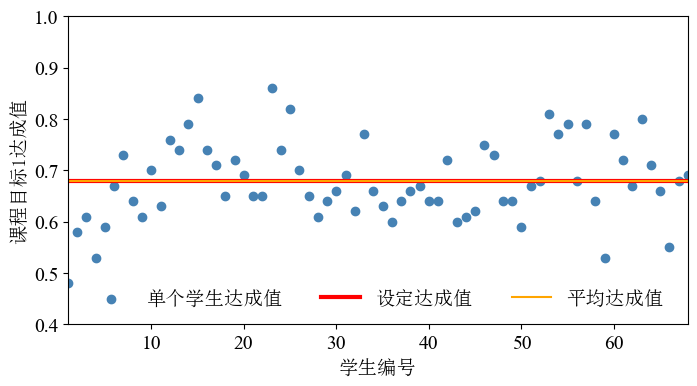

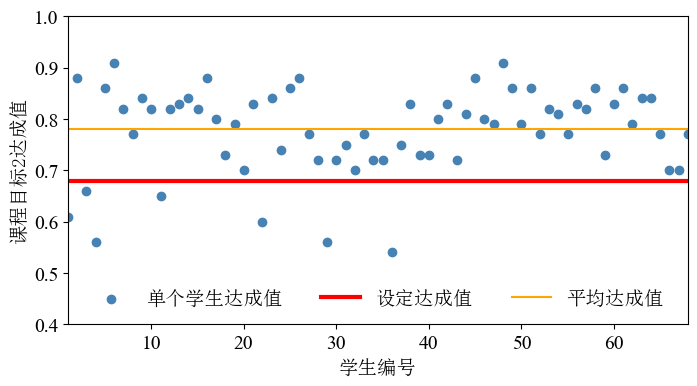

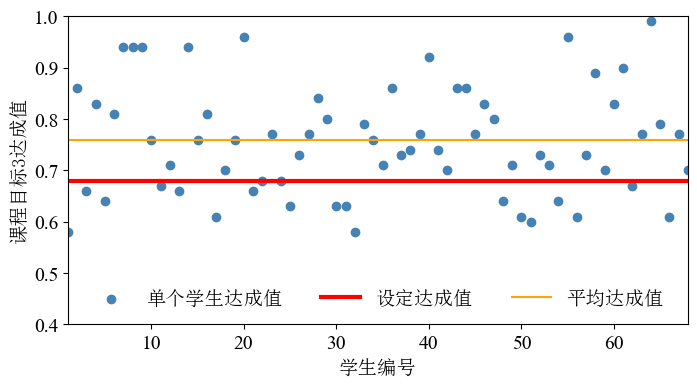

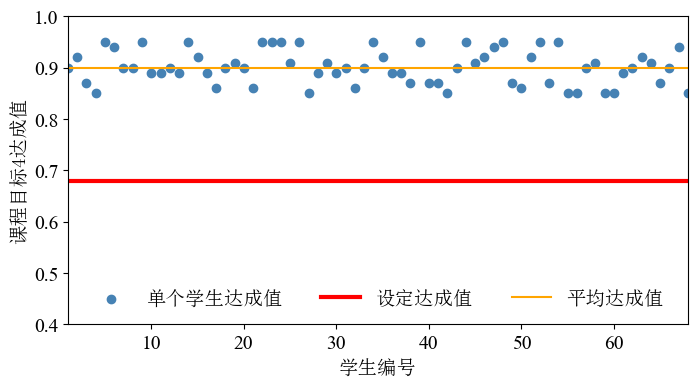

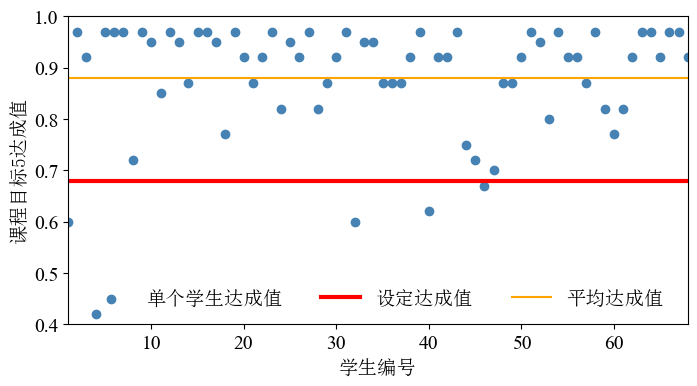

In [48]:

for i in Course_target_numlist:
    Plot_Figure_Coursetarget_NumX(target_num=i, 
                                    W_value_allStudent_ADC_arr = W_value_allStudent_ADC_arr,
                                    W_mean_value_ADC_arr = W_mean_value_ADC_arr,
                                    W_Setting_ADC = W_Setting_ADC)

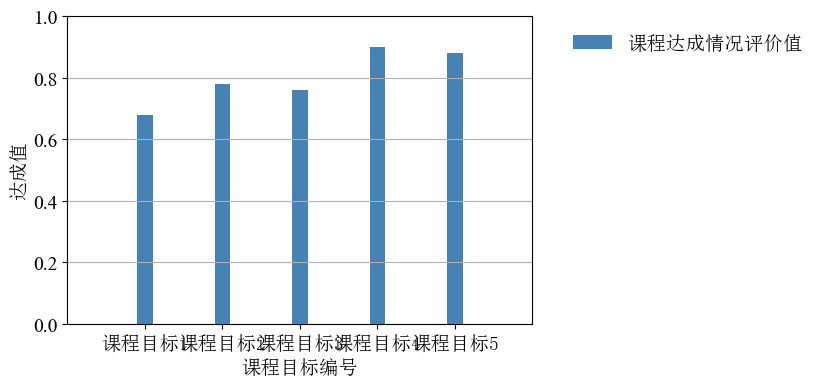

In [46]:

Num_coursetarget_arr = np.arange(1, Num_coursetarget+1, 1)  # 课程目标序列 
W_mean_value_ADC_arr   # 达成度平均值

# 绘图函数 - 课程目标num_X - 柱状图
#柱状图
fig, ax = plt.subplots( figsize=(6, 4) )
font_xylable = {'family':  'simsun', # 宋体
        'color':  'k',
        'weight': 'normal',
        'size': 14,
        }
        
font_legend = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 14,
        }
# plt.grid(b=True, which = 'both',axis='y')
plt.grid(True, axis='y')

plt.bar(Num_coursetarget_arr, W_mean_value_ADC_arr , width=0.2 ,color='steelblue', label=f'课程达成情况评价值')


# ax.set_xlabel/ax.set_ylabel 设置 
ax.set_xlabel('课程目标编号', fontdict=font_xylable, rotation = 0)
ax.set_ylabel('达成值', fontdict=font_xylable, rotation =90) # rotation = 45 旋转45°

# X/Y轴的限制 + 刻度间隔
plt.xlim([0, Num_coursetarget+1])
plt.ylim([0, 1])

# 重定义X-label
nameconv_list = []
for i in np.arange(1, Num_coursetarget+1, 1):
        nameconv_list.append(f'课程目标{i}') 
plt.xticks(np.arange(1, Num_coursetarget+1, 1) , nameconv_list, rotation=0) # nameconv_list  #字体在下面设置 labels = ax.get_xticklabels()

# legend 字体 + 大小
plt.legend(prop = font_set, frameon =False,ncol =3, bbox_to_anchor=(1.05,1.0)) # ncol =1/2 垂直/水平 
# ax4.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)     ##设置ax4中legend的位置，将其放在图外
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=14)
labels = ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 
labels = ax.get_xticklabels()
[label.set_fontname('simsun') for label in labels] 

# 保存
Figure_savepath = "课程目标绘图"
if not os.path.isdir(Figure_savepath):
    os.makedirs(Figure_savepath)
plt.savefig( os.path.join(Figure_savepath,f'图4-课程目标达成评价值'+'.png') , bbox_inches='tight', transparent=False, dpi = 600) 
plt.show() 
